### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)

In [3]:
data['logSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')
data[text_columns] = data[text_columns].fillna('None')

In [5]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
data['FullDescription'] = data['FullDescription'].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())
data['Title'] = data['Title'].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())

In [6]:
from collections import Counter

token_counts = Counter()
for sent in list(map(str.split,data['FullDescription'])):
    for word in sent:
        token_counts[word] += 1
        

for sent in list(map(str.split,data['Title'])):
    for word in sent:
        token_counts[word] += 1



In [7]:
vocab = [word[0] for word in list(filter(lambda x: x[1]>5, list(token_counts.items())))]

In [8]:
UNK,PAD = 'UNK','PAD'
vocab = [UNK,PAD] + vocab

word_to_ind = {word: i for i,word in enumerate(vocab)}

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as f

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
UNK_IX, PAD_IX = 0,1
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [word_to_ind.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [13]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  551  2377     1     1     1]
 [  540 10982   393   309    33]]


In [14]:
from sklearn.feature_extraction import DictVectorizer
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [15]:
for col in data.columns:
    print(f'{col} количетсов уникальных значений: {data[col].nunique()}')

Id количетсов уникальных значений: 244768
Title количетсов уникальных значений: 129653
FullDescription количетсов уникальных значений: 241180
LocationRaw количетсов уникальных значений: 20986
LocationNormalized количетсов уникальных значений: 2732
ContractType количетсов уникальных значений: 3
ContractTime количетсов уникальных значений: 3
Company количетсов уникальных значений: 1001
Category количетсов уникальных значений: 29
SalaryRaw количетсов уникальных значений: 97286
SalaryNormalized количетсов уникальных значений: 8454
SourceName количетсов уникальных значений: 167
logSalary количетсов уникальных значений: 8454


In [16]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if 'SalaryNormalized' in data.columns:
        batch['SalaryNormalized'] = data['SalaryNormalized'].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=0, pad_ix=1,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [361]:
class SimpleTextDecoder(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,word_to_ind):
        super().__init__()
        self.get_emb = nn.Embedding(num_embeddings,embedding_dim,padding_idx = word_to_ind['PAD'])
        self.conv = nn.Conv1d(embedding_dim,embedding_dim *2,kernel_size=3)
    def forward(self,x):
        emb = self.get_emb(x)
        emb = emb.transpose(2,1)
        conv = self.conv(emb)
        x = torch.max(conv,dim = 2).values
        return x

In [362]:
class SimpleNet(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,word_to_ind,cat_feat):
        super().__init__()
        self.get_vec_title = SimpleTextDecoder(num_embeddings,embedding_dim,word_to_ind)
        self.get_vec_full = SimpleTextDecoder(num_embeddings,embedding_dim,word_to_ind)
        
        self.cat_feat = nn.Linear(cat_feat,embedding_dim)
        
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.2)
        self.lin1 = nn.Linear(embedding_dim *5,300)
        self.lin2 = nn.Linear(300,100)
        self.lin3 = nn.Linear(100,50)
        self.lin4 = nn.Linear(50,1)
        
    def forward(self,batch):
        vec1 = self.get_vec_title(batch['Title'])
        vec2 = self.get_vec_full(batch['FullDescription'])
        
        cat = self.cat_feat(batch['Categorical'])
        
        vec = torch.cat((vec1,vec2,cat),dim = 1)
        x = self.drop(self.relu(self.lin1(vec)))
        x = self.relu(self.lin2(x))
        x = self.drop(self.lin3(x))
        return self.lin4(x)

In [17]:
def train_model(train_data, val_data, model, criterion, optim,batch_len,epoches):
    loss_train = []  # Список для хранения потерь на обучении
    loss_val = []    # Список для хранения потерь на валидации
    mae_train = []   # Список для хранения MAE на обучении
    mae_val = []     # Список для хранения MAE на валидации
    final_val_preds = []  # Для хранения предсказаний на валидации в последней эпохе

    plt.figure(figsize=(10, 5))  # Инициализация графика

    for epoch in range(epoches):  # Количество эпох
        model.train()  # Переключаем модель в режим обучения
        train_loss = 0.0  # Накопительная ошибка для обучения
        train_preds = []
        train_targets = []

        # Обучающий цикл по батчам
        for num in range(0, len(train_data), batch_len):  # Шаг = 50
            batch = train_data[num:num + batch_len]  # Формируем батч
            make = make_batch(batch)  # Преобразуем данные в нужный формат

            # Получаем реальные значения и предсказания
            y_true = make['SalaryNormalized'].float()
            y_pred = model(make).float()

            # Вычисляем ошибку
            loss = criterion(y_pred.squeeze(), y_true)

            # Обратное распространение ошибки
            optim.zero_grad()
            loss.backward()  # Исправлено с .backwards() на .backward()
            optim.step()

            # Суммируем потери
            train_loss += loss.item()
            train_preds.append(y_pred.detach().cpu())
            train_targets.append(y_true.cpu())

        # Рассчитываем MAE для тренировки
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        mae_train.append(mean_absolute_error(train_targets, train_preds))

        # Сохраняем среднюю потерю за эпоху
        loss_train.append(train_loss / len(train_data))

        # Оценка на валидационных данных
        model.eval()  # Переключаем модель в режим валидации
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():  # Отключаем градиенты для валидации
            for val in range(0, len(val_data), batch_len):
                val_batch = val_data[val:val + batch_len]
                val_make = make_batch(val_batch)

                val_true = val_make['SalaryNormalized'].float()
                val_pred = model(val_make).float()

                loss = criterion(val_pred.squeeze(), val_true)
                val_loss += loss.item()
                val_preds.append(val_pred.cpu())
                val_targets.append(val_true.cpu())

        # Рассчитываем MAE для валидации
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        mae_val.append(mean_absolute_error(val_targets, val_preds))

        # Сохраняем среднюю потерю за валидацию
        loss_val.append(val_loss / len(val_data))

        # Сохраняем предсказания на валидации в последней эпохе
        if epoch == epoches-1:
            final_val_preds = val_preds

        # Печатаем результаты за эпоху
        print(f"Epoch {epoch+1}/{10}, Train Loss: {loss_train[-1]:.4f}, Val Loss: {loss_val[-1]:.4f}, Train MAE: {mae_train[-1]:.4f}, Val MAE: {mae_val[-1]:.4f}")

        # Визуализация потерь и MAE на текущей эпохе
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(loss_train, label='Train Loss')
        plt.plot(loss_val, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(mae_train, label='Train MAE')
        plt.plot(mae_val, label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Training and Validation MAE')
        plt.legend()
        plt.grid(True)

        plt.pause(0.1)  # Обновление графика на каждой эпохе

    plt.show()
    return loss_train, loss_val, mae_train, mae_val, final_val_preds


In [370]:
net = SimpleNet(len(vocab),200,word_to_ind,3768)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Epoch 1/10, Train Loss: 1842872.6543, Val Loss: 1175856.9865, Train MAE: 9332.4912, Val MAE: 7620.7920


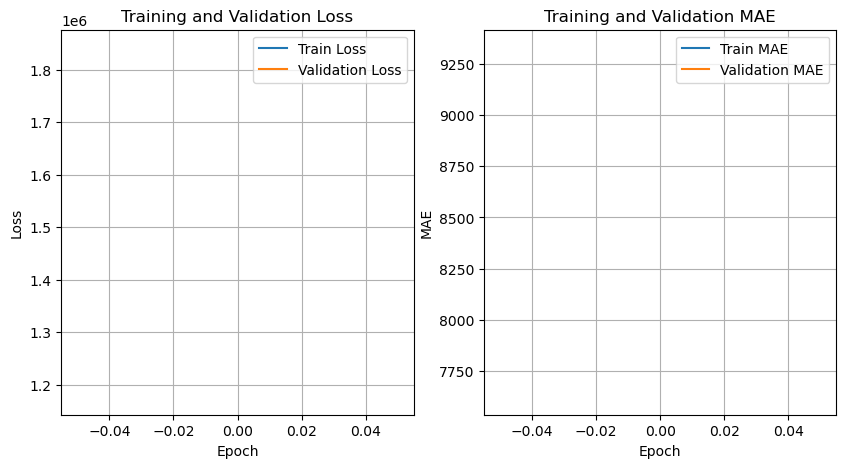

Epoch 2/10, Train Loss: 1111623.5683, Val Loss: 940478.4560, Train MAE: 7293.5024, Val MAE: 6576.1045


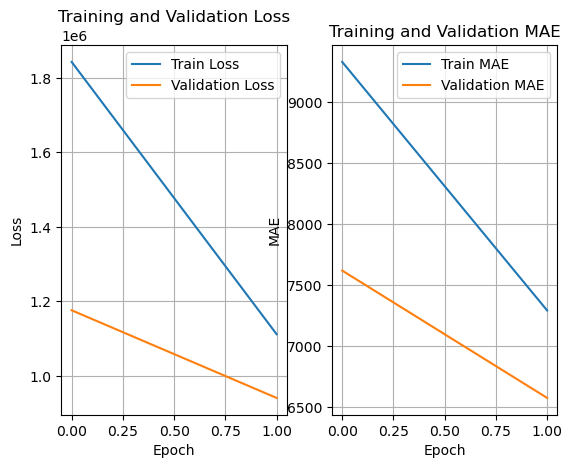

Epoch 3/10, Train Loss: 898460.6477, Val Loss: 854576.0949, Train MAE: 6503.9146, Val MAE: 6186.3579


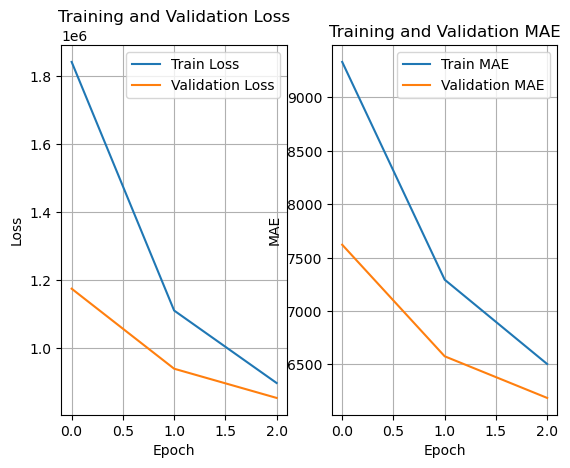

Epoch 4/10, Train Loss: 746398.1906, Val Loss: 801676.7990, Train MAE: 5935.7290, Val MAE: 5913.7690


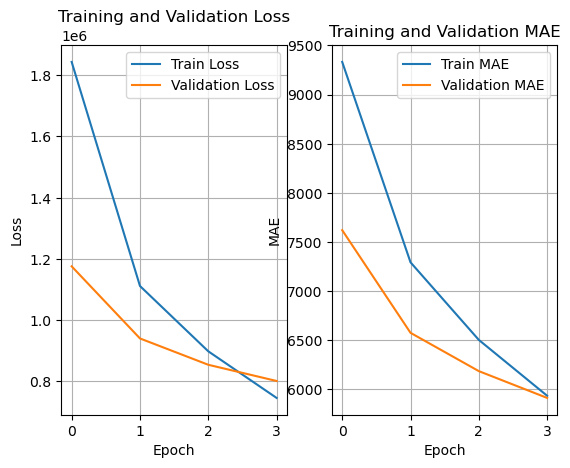

Epoch 5/10, Train Loss: 622679.5530, Val Loss: 816714.5506, Train MAE: 5468.4810, Val MAE: 5877.1680


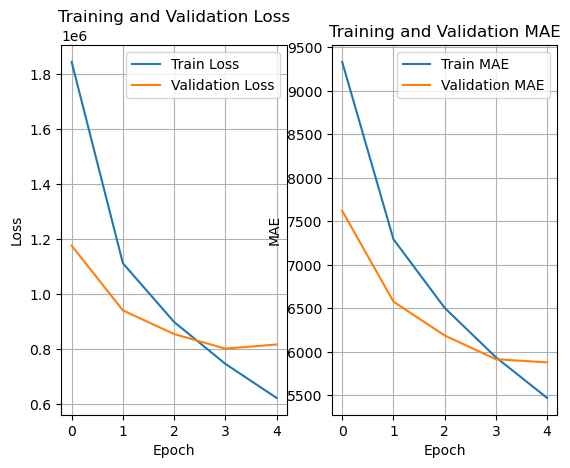

Epoch 6/10, Train Loss: 523007.6769, Val Loss: 771399.5145, Train MAE: 5072.6182, Val MAE: 5652.2090


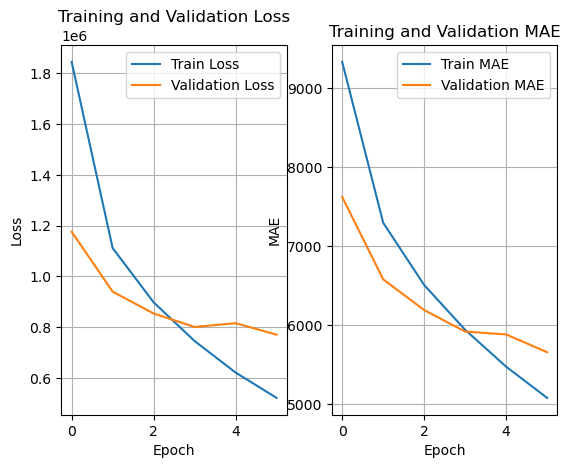

Epoch 7/10, Train Loss: 446932.2353, Val Loss: 759339.5757, Train MAE: 4749.6021, Val MAE: 5580.0059


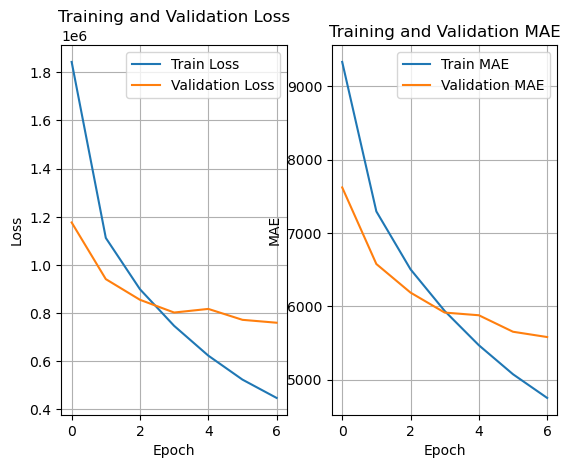

Epoch 8/10, Train Loss: 398254.5089, Val Loss: 760829.9569, Train MAE: 4529.0547, Val MAE: 5537.0767


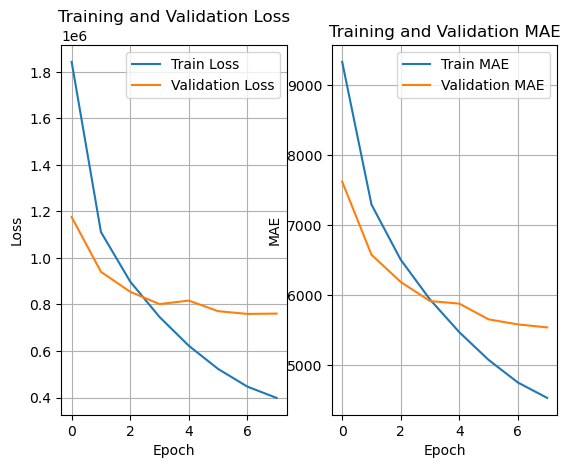

Epoch 9/10, Train Loss: 373987.2982, Val Loss: 808400.4009, Train MAE: 4410.6089, Val MAE: 5964.4302


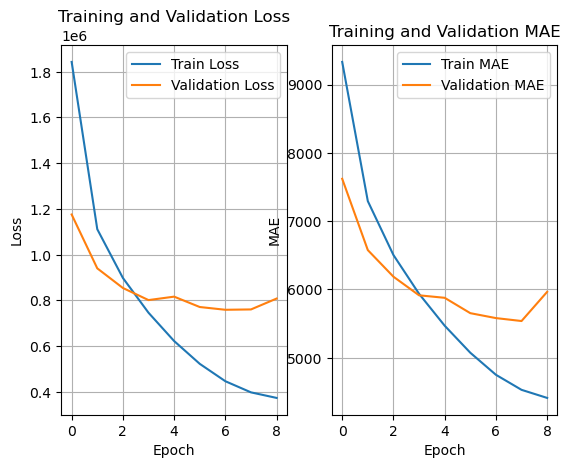

Epoch 10/10, Train Loss: 365424.7076, Val Loss: 728425.9171, Train MAE: 4363.1260, Val MAE: 5530.6411


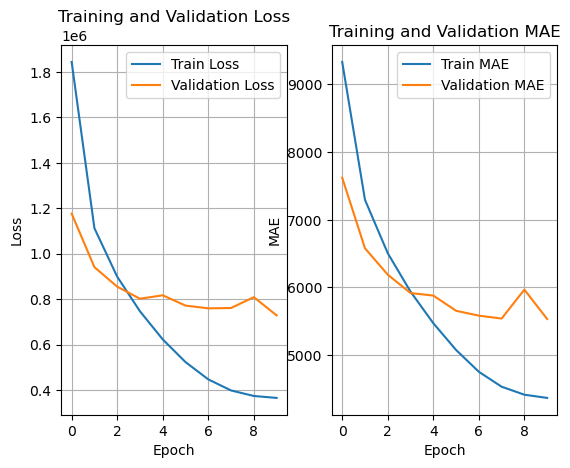

In [371]:
los,toc,_,_,pred = train_model(data_train,data_val,net,criterion,optimizer,100,10)

In [252]:
from sklearn.metrics import r2_score

In [372]:
r2_score(data_val['SalaryNormalized'],pred)

0.7660986660888274

Испытание 2

Взять max_pooling, сделать несколько сверточных слоев decodere, с разными kernel_size 

In [365]:
class SimpleTextDecoder1(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,word_to_ind):
        super().__init__()
        self.get_emb = nn.Embedding(num_embeddings,embedding_dim,padding_idx = word_to_ind['PAD'])
        self.conv1 = nn.Conv1d(embedding_dim,embedding_dim,kernel_size=2)
        self.conv2 = nn.Conv1d(embedding_dim,embedding_dim,kernel_size=3)
        self.conv3 = nn.Conv1d(embedding_dim,embedding_dim,kernel_size=4)
    def forward(self,x):
        emb = self.get_emb(x)
        emb = emb.transpose(2,1)
        conv1 = self.conv1(emb)
        conv2 = self.conv2(emb)
        conv3 = self.conv3(emb)
        x1 = torch.max(conv1, dim=2).values
        x2 = torch.max(conv2, dim=2).values
        x3 = torch.max(conv3, dim=2).values

        
        x = torch.cat((x1,x2,x3),dim = 1)
        return x

In [366]:
class SimpleNet1(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,word_to_ind,cat_feat):
        super().__init__()
        self.get_vec_title = SimpleTextDecoder1(num_embeddings,embedding_dim,word_to_ind)
        self.get_vec_full = SimpleTextDecoder1(num_embeddings,embedding_dim,word_to_ind)
        
        self.cat_feat = nn.Linear(cat_feat,embedding_dim)
        
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.1)
        self.lin1 = nn.Linear(embedding_dim *7,300)
        self.lin2 = nn.Linear(300,100)
        self.lin3 = nn.Linear(100,50)
        self.lin4 = nn.Linear(50,1)
        
    def forward(self,batch):
        vec1 = self.get_vec_title(batch['Title'])
        vec2 = self.get_vec_full(batch['FullDescription'])
        
        cat = self.cat_feat(batch['Categorical'])
        
        vec = torch.cat((vec1,vec2,cat),dim = 1)
        x = self.drop(self.relu(self.lin1(vec)))
        x = self.relu(self.lin2(x))
        x = self.drop(self.relu(self.lin3(x)))
        return self.lin4(x)

In [367]:
net1 = SimpleNet1(len(vocab),100,word_to_ind,3768)
criterion = nn.MSELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)

Epoch 1/10, Train Loss: 2027380.4367, Val Loss: 1238537.1484, Train MAE: 9777.8145, Val MAE: 7785.6777


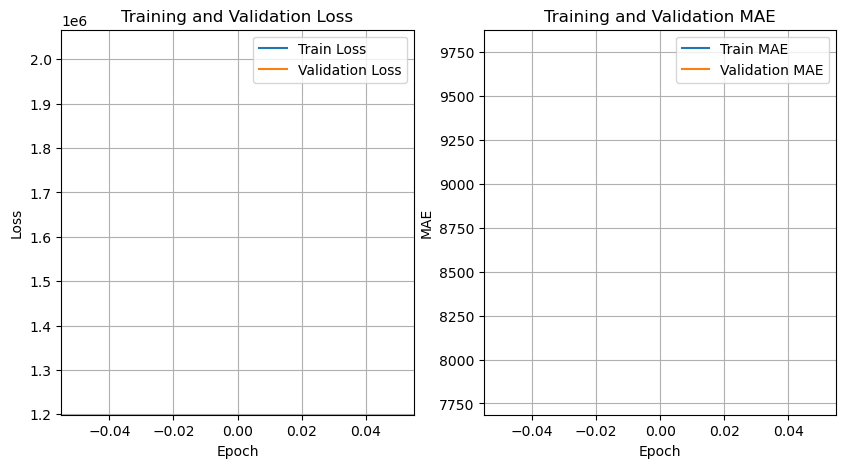

Epoch 2/10, Train Loss: 1184493.8666, Val Loss: 1036969.9557, Train MAE: 7551.6084, Val MAE: 7059.3003


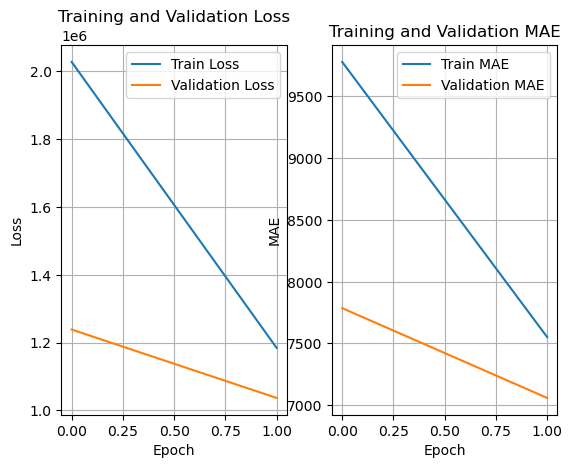

Epoch 3/10, Train Loss: 957335.8487, Val Loss: 906909.6123, Train MAE: 6720.6582, Val MAE: 6474.6616


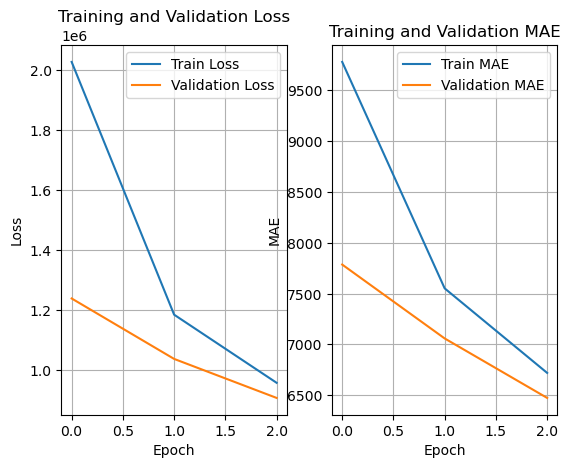

Epoch 4/10, Train Loss: 806499.4641, Val Loss: 845824.7569, Train MAE: 6137.4219, Val MAE: 6169.1929


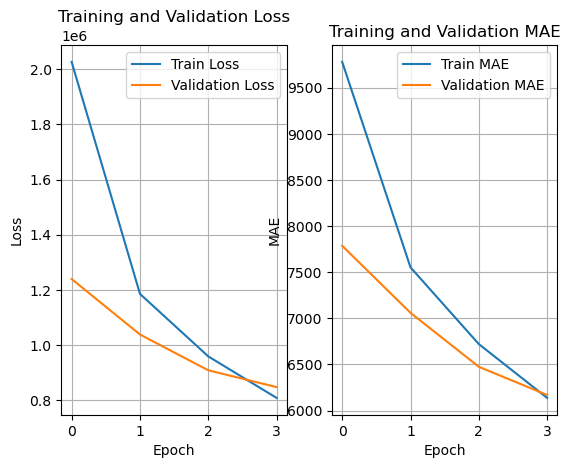

Epoch 5/10, Train Loss: 689516.1695, Val Loss: 805285.7667, Train MAE: 5670.6377, Val MAE: 5962.5698


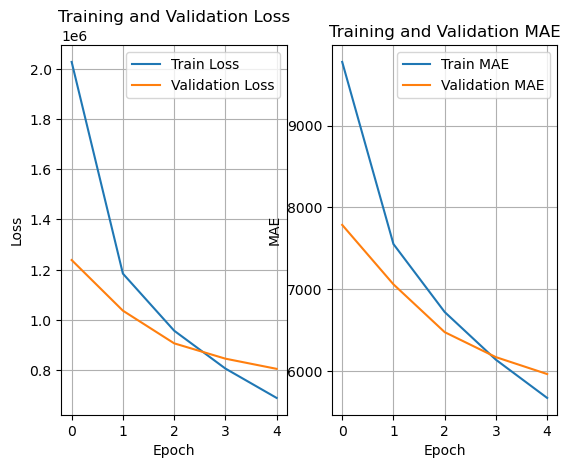

Epoch 6/10, Train Loss: 585594.3409, Val Loss: 785706.9833, Train MAE: 5256.1538, Val MAE: 5803.8418


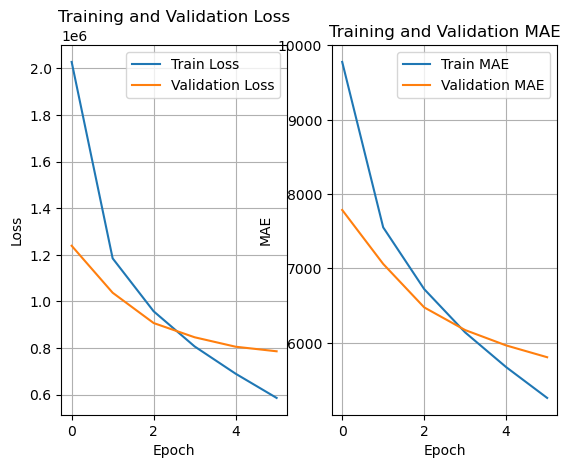

Epoch 7/10, Train Loss: 495116.3815, Val Loss: 773993.5044, Train MAE: 4867.1968, Val MAE: 5757.2114


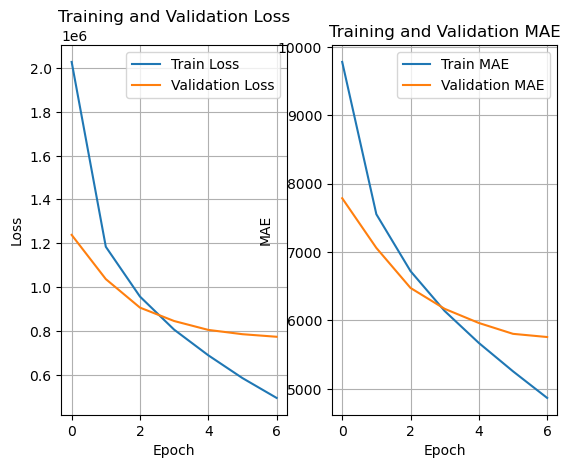

Epoch 8/10, Train Loss: 420845.5021, Val Loss: 765851.2210, Train MAE: 4536.8979, Val MAE: 5664.1646


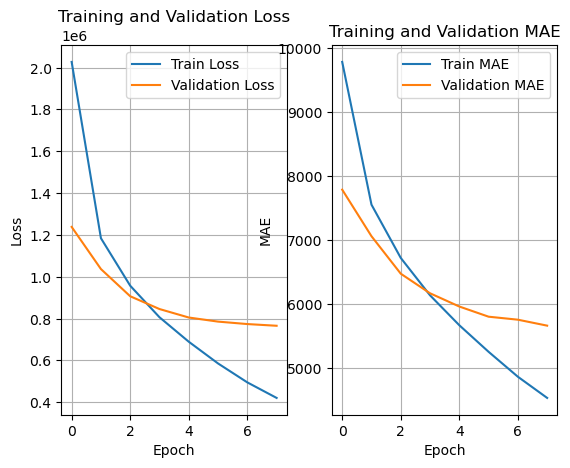

Epoch 9/10, Train Loss: 359365.4971, Val Loss: 769239.3818, Train MAE: 4241.3574, Val MAE: 5634.8066


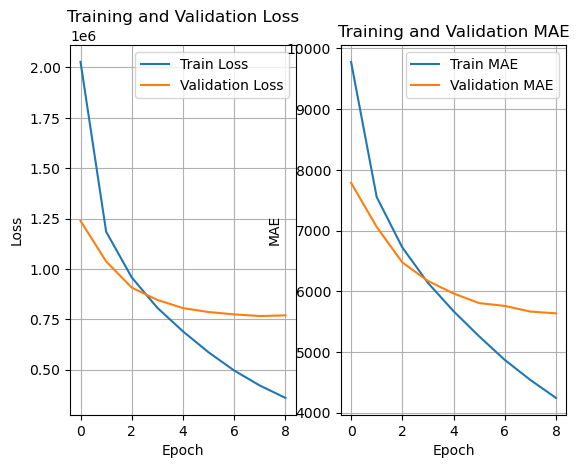

Epoch 10/10, Train Loss: 315050.6788, Val Loss: 817882.5997, Train MAE: 4010.1257, Val MAE: 5737.2222


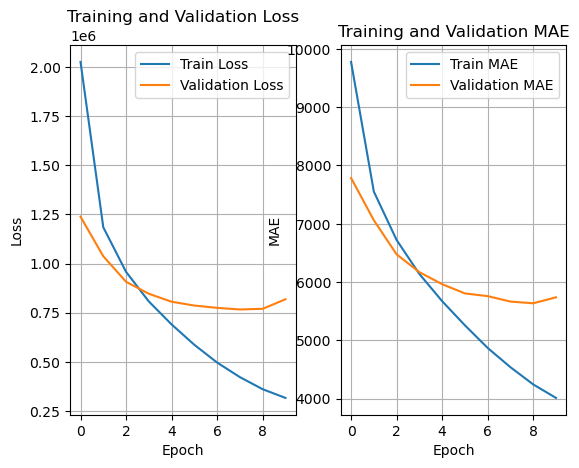

In [368]:
los,toc,_,_,pred = train_model(data_train,data_val,net1,criterion,optimizer,100,10)

In [369]:
r2_score(data_val['SalaryNormalized'],pred)

0.7374829857485645

Испытание 3 Использовать в decodere bilstm

In [18]:
class SimpleTextDecoder2(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,hidden_dim,num_dim,word_to_ind):
        super().__init__()
        self.get_emb = nn.Embedding(num_embeddings,embedding_dim,padding_idx = word_to_ind['PAD'])
        self.lstm = nn.LSTM(input_size = embedding_dim,
                            hidden_size = hidden_dim, 
                            num_layers = num_dim,
                            batch_first=True,
                            bidirectional=True)
    def forward(self,x):
        emb = self.get_emb(x)
        
        out, _ = self.lstm(emb)
        out = torch.cat((out[:, -1, :self.lstm.hidden_size],  
                    out[:, 0, self.lstm.hidden_size:]), 
                dim=1)
        return out

In [19]:
class SimpleNet2(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,hidden_dim,num_dim,word_to_ind,cat_feat):
        super().__init__()
        self.get_vec_title = SimpleTextDecoder2(num_embeddings,embedding_dim,hidden_dim,num_dim,word_to_ind)
        self.get_vec_full = SimpleTextDecoder2(num_embeddings,embedding_dim,hidden_dim,num_dim,word_to_ind)
        
        self.cat_feat = nn.Linear(cat_feat,hidden_dim)
        
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)
        input_dim = hidden_dim * 2 * 2 + hidden_dim
        self.lin1 = nn.Linear(input_dim,300)
        self.lin2 = nn.Linear(300,100)
        self.lin3 = nn.Linear(100,50)
        self.lin4 = nn.Linear(50,1)
        
    def forward(self,batch):
        vec1 = self.get_vec_title(batch['Title'])
        vec2 = self.get_vec_full(batch['FullDescription'])
        
        cat = self.cat_feat(batch['Categorical'])
        
        vec = torch.cat((vec1,vec2,cat),dim = 1)
        x = self.drop(self.relu(self.lin1(vec)))
        x = self.relu(self.lin2(x))
        x = self.drop(self.relu(self.lin3(x)))
        return self.lin4(x)

In [20]:
net3 = SimpleNet2(len(vocab),200,100,1,word_to_ind,3768)
criterion = nn.MSELoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

In [21]:
los,toc,_,_,pred = train_model(data_train,data_val,net3,criterion,optimizer,50,10)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1394853816 bytes.

<Figure size 1000x500 with 0 Axes>

In [ ]:
r2_score(data_train['SalaryNormalized'],pred)

### A short report
1. Попробовал текстовый декодер с 1 сверткой и 1 переводом в эмбеддинг размерностью 400 для title и 200 для категориальных. В самой нейросети использовал 3 скрытых слоя с LeakyRelu и Dropout (BatchNorm показал результат хуже). Результатом обучения на 10 эпохах стало MAE = 5380 и r2_score на валидационной в 0.76

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

In [24]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
